In [1]:
loadpackages = function(){
  suppressMessages(require(tidyverse))
  suppressMessages(require(brms))
  suppressMessages(require(patchwork))
  suppressMessages(require(bayesplay))
  suppressMessages(require(BayesFactor))
  suppressMessages(require(logspline))
  suppressMessages(require(furrr))
  suppressMessages(require(tidyverse))
  suppressMessages(require(magrittr))
  suppressMessages(require(logspline))
  suppressMessages(require(patchwork))
  suppressMessages(require(IRdisplay))

}

loadpackages()

# The P Value



The American Statistical Association (ASA) defines a *p* value as:

> the probability under a specified statistical model that a statistical summary of the data (e.g., the sample mean difference between two compared groups) would be equal to or more extreme than its observed value [@wasserstein2016, my emphasis]

While this is a perfectly acceptable definition it is maybe a little tricky to understand. The main reason for this is that the definition contains at least one *ill-defined concept* ("probability") and one tricky concept ("specified statistical model"). To understand what a *p* value really is, we're going to have to unpack both of these ideas. Along the way we're going to learn about some other concepts that will also help us understand *Frequentist* inference. And a good grounding in Frequentist inference will also help use understand the distinction between Frequentist inference and Bayesian inference. 

## Probability

Most people think of *probability* as a mathematical concept. In a sense it is, but it is also a deeply *philosophical* concept. We deploy the word *probability* in many different *kinds* of situations and it's not clear whether we mean the same thing in each of them. Some examples of where we use the word probability is when we ask questions like: What is the probability of getting heads on repeated tosses of a fair coin?  What is the probability that it will rain tomorrow? What is the probability the criminal committed the crime? The word *probability* seemingly refers to different things in each of these situations. 

For example, we might suggest that the probability of the getting heads is 0.5 where this 0.5 refers to the *long run relative frequency* of getting heads. That is, if we were to toss a coin many many times then on around 0.5 (i.e., half) of the tosses the coin would come up heads.

We might use a different notion when thinking about the case of the criminal. We might say something like, "we are 90% sure" (probability of .9) that the criminal committed the crime. But what does "90% sure" mean. Does it make sense to think of it as the *relative frequency*? If not, then how else might be think of it? We might, for example, think of it as a *credence* or a *degree of belief* that the proposition is true. Or we might think of it as a *degree of support*. That is, we might say that the available evidence supports the hypothesis that the criminal committed the crime with odds of 9-to-1.

This isn't meant to be an exhaustive list of definitions. The aim is just to highlight that we might sometimes mean different things when we think about probability. It pays to keep this in minds as we move through the course. 

## Probability and *p* values

Now that we know that *probability* can mean different things in different situations, what notion of *probability* is at play in ASA's definition of the *p* value. The common view is to say that it refers to *relative frequencies*. But relative frequencies of **what** over repeats of **what**? 

> the p value refers to the relative frequency of obtaining a statistical summary of the data as large or larger than the observed value over hypothetical repeats of an experiment described by a specified statistical model

### Understanding the *p* through simulation

To understand how *p* values work let's start off with a little scenario: 


> You've been given a device that can be used for finding buried treasure. The device has a numbered dial on it, and there is a little arrow that can point at these numbers. The arrow never stays still, but swings around a bit. You don't know how the device works, expect that it behaves *differently* around treasure compared with when there is no treasure present. How can you use this device to find treasure?

This seems like hard problem. You know very little about the device. You don't know what it's meant to do when it finds treasure, and you don't know what it's meant to do when there isn't any treasure. So how do you go about using it to find treasure?

#### Finding treasure 

The first step to using the device is to get a good description of what it does when there isn't any treasure around. You take your device somewhere there's no treasure, and you just sit and watch the dial. After a long time watching it you notice that although the pointer swings around a lot, *on average* it points at zero. This one bit of information is enough to develop a treasure hunting strategy using this device. 

The first step in the strategy is deciding how many readings to take on each hunt. Because the pointer swings around a lot, we'll need to take a couple of readings and then use these to work out an average (which we'll call $\bar{x}$). We're in a hurry so we'll take **10** readings on each hunt. 

Next, we'll need to scale our average. If our average is 1 then is this close to 0? How about 0.5? or 5? or 15? It's impossible to know, because you don't know how big the average range of it's swings are. So your scaling factor should be proportional to the magnitude of the average deviations you've observed (we'll call this scaling factor $s_{\bar{x}}$).

With this information in hand, we have enough to build a statistical model of our device's behaviour. To do this, we just go where there is no treasure and perform the following steps: 1) Take 10 readings; 2) work our an average ($\bar{x}$); 3) scale it by our scaling factor ($s_{\bar{x}}$); write down our scaled measurement (which we'll call $t$); and repeat!  Once we've done this many many times then we'll have a nice distribution or statistical model of how our device behaves when there isn't any treasure. Of course, we don't have to do this for real. We can just simulate it!


In [2]:
# 1
# run this chunk to set up the simulation function

set.seed(612) # Set the seed for reproducibility

run.exp = function(sample_size, average){
  # define function for running and experiment
  
      
    # we don't know how much the pointer actually swings around,
    # so lets just pick a random range between 1 and 10!
    dev = runif(1,1,10); min_possible = 0 -dev; max_possible = 0 + dev
  
    # generate a sample of readings
    this_sample = runif(sample_size, min_possible, max_possible)
  
  # make descriptive stats
  tibble::tibble(sample_mean = mean(this_sample), 
                 sample_sd = sd(this_sample), 
                 n = sample_size,
                 se = sample_sd / sqrt(sample_size))
}

In [3]:
# 2
# run this chunk to actually run the simulations!

future::plan("multiprocess") # Set to run in parallel
no_of_exps = 100000 # Set the number of experiments to simulate
all_exps <- furrr::future_map_dfr(1:no_of_exps, function(x) 
  run.exp(sample_size = 10, average = 0) %>% dplyr::mutate(i = x)) # run the experiments

dplyr::glimpse(all_exps) # view the results

Observations: 100,000
Variables: 5
$ sample_mean <dbl> 0.24773030, -0.51012705, 0.08996398, 1.13376593, 0.232675…
$ sample_sd   <dbl> 0.6261914, 0.9511805, 1.1865844, 1.4667853, 2.3075037, 1.…
$ n           <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1…
$ se          <dbl> 0.1980191, 0.3007897, 0.3752309, 0.4638382, 0.7296968, 0.…
$ i           <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…


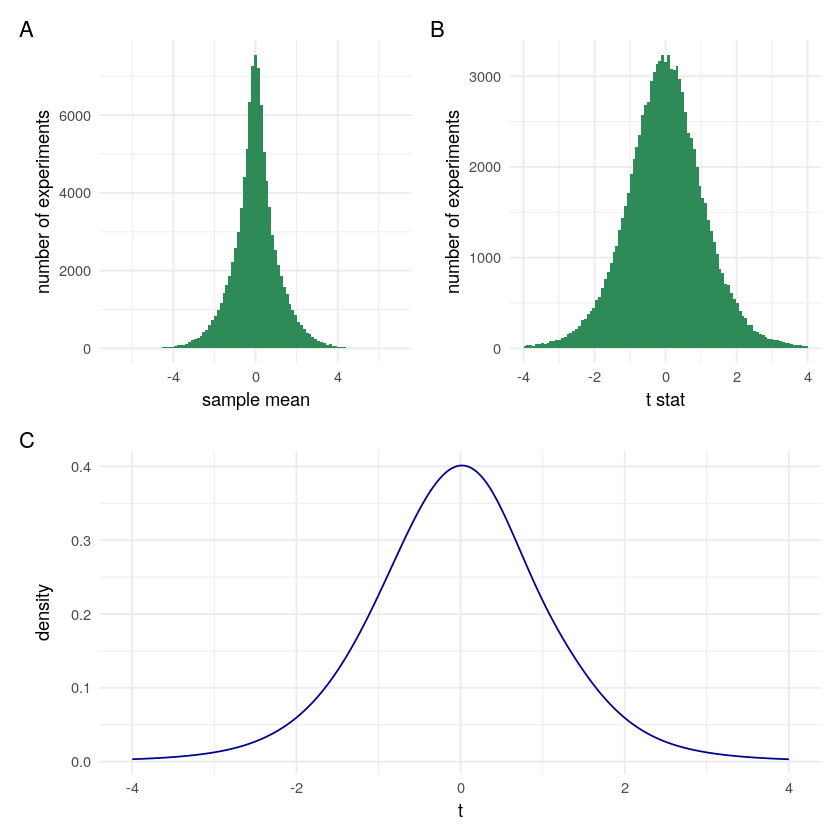

In [4]:
# 3
# run this chunk to view some plots of our simulations
all_exps %<>% mutate(t = (sample_mean * sqrt(n)) / sample_sd)

# make a histogram of the unscaled averages
all_exps %>% ggplot(aes(x = sample_mean)) + geom_histogram(fill = "seagreen",bins = 100, na.rm = TRUE) +
  labs(x = "sample mean", y = "number of experiments") + 
  xlim(c(-max(abs(all_exps$sample_mean)) * 1.10, max(abs(all_exps$sample_mean)) * 1.10)) +
  theme_minimal() -> mean_hist

# make a histograme of the scaled averages
all_exps %>% ggplot(aes(x = t)) + geom_histogram(fill = "seagreen", bins = 100, na.rm = TRUE) +
  labs(x = "t stat", y = "number of experiments") + xlim(c(-4,4)) +
  theme_minimal() -> t_hist

# convert the histogram of the scaled averages to a probability density
tibble(x = seq(-4, 4, length.out = 10000)) %>% 
  mutate(y = dlogspline(x,logspline(all_exps$t))) %>%
  ggplot(aes(x = x, y = y)) + geom_line(colour = "darkblue") +
  labs(x = "t", y = "density") + xlim(c(-4,4)) +
  theme_minimal() -> density_plot


((mean_hist | t_hist) / density_plot ) + plot_annotation(tag_levels = "A")

In [5]:
# 4
# trying out our treasure hunting device
set.seed(151); X = rnorm(10, runif(1,-10,10), runif(1));

x_bar = mean(X) # work out an average
s_x_bar = sd(X)/sqrt(length(X)) # work out the scaling factor
t_value = x_bar / s_x_bar # work out the scaled measurement 

glue::glue("Our {length(X)} measurements are: {glue::glue_collapse(round(X,2),sep = '; ')}  
           Our $\\bar{{x}}$ = {round(x_bar,3)}  
           Our $s_\\bar{{x}}$ = {round(s_x_bar,3)}      
This means that our scaled measurement, $t$ = {round(t_value,3)}") %>% 
IRdisplay::display_markdown()

Our 10 measurements are: 0.25; -0.54; -0.51; -0.75; 0.27; -1.62; -1.29; -0.21; 0.17; -0.83  
           Our $\bar{x}$ = -0.507  
           Our $s_\bar{x}$ = 0.204      
This means that our scaled measurement, $t$ = -2.485

In [6]:
# 5
# how surprising is our measurement

# first convert it to an absolute value
t_value = abs(t_value)

larger_than_positive = mean(all_exps$t > t_value)
smaller_than_negative = mean(all_exps$t < -t_value)

further_from_zero = larger_than_positive + smaller_than_negative
closer_to_zero = 1 - further_from_zero

glue::glue("{round(closer_to_zero * 100,2)}% of values from our simulation where closer to zero than our current value.   
Only {round(further_from_zero * 100, 2)}% of values where further from zero than our current value.") %>%
IRdisplay::display_markdown()

96.17% of values from our simulation where closer to zero than our current value.   
Only 3.83% of values where further from zero than our current value.

In [7]:
# 6
# testing our rule
set.seed(14) # set seed for reproducibly
n_tests = 10000 # set the number of tests

Pr_treasure = runif(1) # Set the probablity of finding treasure

simulate_hunt <- function(Pr_treasure){
    
    # Decide whether this hunt has treasure
    has.treasure = ifelse(runif(1) < Pr_treasure, 1, 0) 
    
    X = rnorm(10, has.treasure, 1.5) # generate 10 readings
    
    # work out the scaled measurement and how suprising it is
    # and decide whether to dig or not!
    t.test(X) %>% broom::tidy() %>%
  mutate(has.treasure = ifelse(has.treasure == 1, "Y","N"), 
         how.suprising = p.value, 
         dig = ifelse(p.value < 0.05, "Y","N")) %>%
  select(has.treasure, dig)
    
}

set.seed(11) # set seed for reproducibly
test_hunts = furrr::future_map_dfr(1:n_tests, function(x) simulate_hunt(Pr_treasure)) 

In [8]:
# 7
# look at the results of tests

test_hunts %>% slice(1:20) %>% knitr::kable(format = "html", 
                                            col.names = c("Had treasure?","Dig or not?")) %>% 
as.character() %>% IRdisplay::display_html()


Had treasure?,Dig or not?
N,N
N,N
N,N
N,N
N,N
N,N
N,N
N,N
N,N
N,N


In [9]:
#8 

# function for computing metrics
get_metrics = function(test_hunts){
    test_hunts %<>% mutate(type = case_when(has.treasure == "Y" & dig == "Y" ~ "Hit", 
                                            has.treasure == "Y" & dig == "N" ~ "Miss",
                                            has.treasure == "N" & dig == "N" ~ "Correct Rejection",
                                            has.treasure == "N" & dig == "Y" ~ "False alarm"))

    metrics = test_hunts %>% 
    mutate(type = factor(type,levels = c("Hit","Miss","Correct Rejection","False alarm"))) %>% 
    group_by(type, `.drop` = FALSE) %>% summarise(n = n()) %>% mutate(type = as.character(type)) %>%
    pivot_wider(names_from = "type", values_from = "n") %>% 
    mutate(Correct = `Correct Rejection` + Hit, 
       Incorrect = `False alarm` + Miss, 
       Accuracy = Correct / (Correct + Incorrect)) 

    amount_of_treasure = test_hunts %>% 
    mutate(has.treasure = factor(has.treasure, levels = c("Y","N"))) %>%
    group_by(has.treasure, `.drop` = FALSE) %>% summarise(n = n()) %>%
        spread(key = has.treasure, value = n) %>% 
        set_colnames(c("N" = "No treasure", "Y" = "Treasure")) %>% 
        mutate(`actual Pr_treasure` = `Treasure` / (`No treasure` + `Treasure`))

    cbind(metrics,amount_of_treasure)
    
    
}


In [10]:
# 9
# Get some metrics for your simulated hunt
test_hunts %>% get_metrics()

Hit,Miss,Correct Rejection,False alarm,Correct,Incorrect,Accuracy,No treasure,Treasure,actual Pr_treasure
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1173,1337,7084,406,8257,1743,0.8257,2510,7490,0.749


In [11]:
# 10 
furrr::future_map_dfr(1:n_tests, function(x) simulate_hunt(0)) %>% get_metrics()

Hit,Miss,Correct Rejection,False alarm,Correct,Incorrect,Accuracy,No treasure,Treasure,actual Pr_treasure
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
0,0,9509,491,9509,491,0.9509,0,10000,1


In [12]:
# 11
furrr::future_map_dfr(1:n_tests, function(x) simulate_hunt(0)) %>% get_metrics()

Hit,Miss,Correct Rejection,False alarm,Correct,Incorrect,Accuracy,No treasure,Treasure,actual Pr_treasure
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
0,0,9529,471,9529,471,0.9529,0,10000,1


In [13]:
get_metrics2 = function(.data){
    .data %>% mutate(`False alarm rate` = `False alarm`/(`No treasure` + `Treasure`),
                            `Miss rate` = `Miss` / (`No treasure` + `Treasure`))
}

In [14]:
furrr::future_map_dfr(1:10000, function(x) simulate_hunt(.5)) %>% get_metrics() %>% get_metrics2()
                      

Hit,Miss,Correct Rejection,False alarm,Correct,Incorrect,Accuracy,No treasure,Treasure,actual Pr_treasure,False alarm rate,Miss rate
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
2319,2661,4759,261,7078,2922,0.7078,4980,5020,0.502,0.0261,0.2661
